## Functions for $\Delta\Sigma$ calculation
#### Zhuowen Zhang
#### Created Sept. 5, 2018

In [1]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty

from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer
from scipy.integrate import quad
from scipy.integrate import romberg
from scipy.interpolate import UnivariateSpline as spline

import sys
import pyfits
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from tools.setup.setup import tools_home_dir, home_dir
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/'
toolsdir = tools_home_dir()
homedir = home_dir()

### ln($\Delta\Sigma$) ratio template (from Heidi Wu)

Extract infor from ds_tplt:
* Columns 0-1: min and max redshift range
* Columns 2-3: min and max mass range
* Columns 4-9: the 6 parameters for Cauchy modeling
* Column 10:   error 
* Column 11:   DOF

In [60]:
ds_tplt_dir = home_dir()+'output/deltasigma/'
ds_tplt_file = ds_tplt_dir + 'fit_cauchy_sqr_errorbar.dat'
ds_tplt = np.genfromtxt(ds_tplt_file, unpack=True)
ds_tplt = ds_tplt.reshape(12, 4, 4)

In [57]:
'''
Cauchy function fit for the DeltaSigma ratio including effects of Triaxiality. Template produced by Heidi
mu: cos(i) as array in range 0-1
x: = ln(rp) rp units of Mpc/h.
z: redshift
m: mass M200b/h in M_sun/h units

Default set to lowest redshift and mass bins.
'''

def lnDS_ratio(mu, x, z=0, m=0):
    global ds_tplt
    z_min = ds_tplt[0]; z_max = ds_tplt[1]
    m_min = ds_tplt[2]; m_max = ds_tplt[3]
    
    z_ind = np.searchsorted(z_max[:,0], z) #Controls columns
    m_ind = np.searchsorted(m_max[0,:], m) #controls the rows
    
    #if higher than max value
    if z_ind == len(z_max[:,0]): z_ind -= 1
    if m_ind == len(m_max[:,0]): m_ind -= 1
    
    #Selecting parameters from bin
    A0 = ds_tplt[4][m_ind, z_ind]
    A1 = ds_tplt[5][m_ind, z_ind]
    A2 = ds_tplt[6][m_ind, z_ind]
    A3 = ds_tplt[7][m_ind, z_ind]
    x0 = ds_tplt[8][m_ind, z_ind]
    gamma = ds_tplt[9][m_ind, z_ind]
    
    print A0, A1, A2, A3, x0, gamma
    
    Ac_cosi = A0 + A1 * mu  + A2 * mu**2 + A3 * mu**3
    lnDS_ratio = Ac_cosi*(1. - 1. / ((x - x0)**2 + gamma))
    return lnDS_ratio

In [59]:
x = np.linspace(-1,3, 100)
lnDS_tplt = lnDS_ratio(0.8, x, z=0.5, m=1.1e17)

plt.plot(x, lnDS_tplt)
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

### Find best fit model parameters

#### Find lnA parameter

In [6]:
'''
Finds the linear amplitude ln(A) in the richness-mass relation using model 3 for different cosine bins. 
Interpolates using spline.

Files should be located in tpltdir and be names as 'p_lmda_cosi_'+str(i)+'_model3' where str(i) refers to the bin number

Input
--------------------
tpltdir = file location as directory
cosi_bins: array of bins in cosine in format [[low1, high1], [low2, high2], [low3, high3]]

Returns:
--------------------
cosi_mid: the mid value for each cosine bin
spl_lnA: spline of lnA using scipy.interpolate.UniveriateSpline
lnA_fit: the actual values of lnA in each cosine bin
'''

def interpolate_A(tpltdir, cosi_bins):
    num_bins = len(cosi_bins)
    cosi_mid = np.zeros_like(cosi_bins)
    
    c = ChainConsumer()
    for i in range(num_bins):
        cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]; 
        cosi_mid[i] = (cosi_bin_min + cosi_bin_max)/2.
        mcmc_folder = tpltdir + 'p_lmda_cosi_'+str(i)+'_model3'
        As = np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
        data = As
        c.add_chain(data, parameters=[r"$A$"], name=r'Template for $cos(i)\in[%.1f, %.1f)$'%(cosi_bin_min, cosi_bin_max))
        c.configure(statistics="max_shortest")

    c_stats = c.analysis.get_summary()

    lnA_fit = np.zeros(len(cosi_bins))
    for i in range(len(c_stats)):
        lnA_fit[i] = np.log(c_stats[i]['$A$'][1]) #mean value of A in each cosine bin. 

    #Build a spline model for lnA
    cosi_mid = [0.1,0.3,0.5,0.7,0.9]
    spl_lnA = spline(cosi_mid, lnA_fit)
    return cosi_mid, spl_lnA, lnA_fit

#### Global best fit for A, B, $\sigma_0$

In [13]:
'''
Finds global best fit for A, the amplitude of richness-mass, using model3

File should be located in tpltdir and be named as 'p_lmda_cosi_all_model3'. 

Input
--------------------
tpltdir = file location as directory

Returns:
--------------------
A_allfit: the global best fit posterior for A
'''

def bestfit_A(tpltdir):
    c = ChainConsumer()
    for i in range(len(cosi_bins)):
        cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
        mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model3'

        Bs=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
        #sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

        data=Bs
        c.add_chain(data, parameters=[r"$A$"], name=r'Template for A')

        c.configure(statistics="max_shortest")
        #c.plotter.plot(filename="p_lmda_cosi_%i_chains.png"%i, figsize="column")

    '''
    funk = c_posterior[i]["$A$"] reads the A parameter statistic of the i-th chain. 
    The statistic is read as array of min, mean, max values of statistic (e.g. max_shhortest),
    so that funk[1], for instance,  is the mean value of A in the ith chain. 
    '''    
    c_stats = c.analysis.get_summary() 
    A_allfit =    c_stats[0]["$A$"][1]
    return A_allfit


'''
Finds global best fit for B, the slope of richness-mass, using model2

File should be located in tpltdir and be named as 'p_lmda_cosi_all_model2'. 

Input
--------------------
tpltdir = file location as directory

Returns:
--------------------
B_allfit: the global best fit posterior for B
'''

def bestfit_B(tpltdir):
    c = ChainConsumer()
    for i in range(len(cosi_bins)):
        cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
        mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model2'

        Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
        #sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

        data=Bs
        c.add_chain(data, parameters=[r"$B$"], name=r'Template for B')

        c.configure(statistics="max_shortest")
        #c.plotter.plot(filename="p_lmda_cosi_%i_chains.png"%i, figsize="column")

    '''
    funk = c_posterior[i]["$A$"] reads the A parameter statistic of the i-th chain. 
    The statistic is read as array of min, mean, max values of statistic (e.g. max_shhortest),
    so that funk[1], for instance,  is the mean value of A in the ith chain. 
    '''    
    c_stats = c.analysis.get_summary() 
    B_allfit =    c_stats[0]["$B$"][1]
    return B_allfit

######################################################################################

'''
Finds global best fit for sig0, the intrinsic scatter of richness-mass, using model2
File should be located in tpltdir and be named as 'p_lmda_cosi_all_model2'. 

Input
--------------------
tpltdir = file location as directory

Returns:
--------------------
sig0_allfit: the global best fit posterior for B
'''

def bestfit_sig0(tpltdir):
    c = ChainConsumer()
    for i in range(len(cosi_bins)):
        cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
        mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all'+'_model2'

        Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
        sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

        data=sig0s
        c.add_chain(data, parameters=[r"$\sigma_0$"], name=r'Template for $\sigma_0$')

        c.configure(statistics="max_shortest")
        #c.plotter.plot(filename="p_lmda_cosi_%i_chains.png"%i, figsize="column")

    '''
    funk = c_posterior[i]["$A$"] reads the A parameter statistic of the i-th chain. 
    The statistic is read as array of min, mean, max values of statistic (e.g. max_shhortest),
    so that funk[1], for instance,  is the mean value of A in the ith chain. 
    '''    
    c_stats = c.analysis.get_summary() 
    sig0_allfit = c_stats[0]["$\sigma_0$"][1]
    return sig0_allfit

### Run best fit parameters to input to function *prob_lambda()*

In [14]:
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_mid, spl_lnA, data_lnA = interpolate_A(tpltdir, cosi_bins)

lnA_allfit = np.log(bestfit_A(tpltdir))
B_allfit = bestfit_B(tpltdir)
sig0_allfit = bestfit_sig0(tpltdir)

### $P(\lambda | M, \mu)$ using best fit values of model parameter for richness-mass
Calcuates the standard deviation of ln$\lambda$ from mean value using the richness-mass relation and scatter. Assumes log-normal scatter. Finds the probablility of producing said value of lnl for given mass. 

In [19]:
###TODO: Import this code when come back. 

from scipy.stats import norm
'''
Finding P(lambda| M, mu), the probability density of finding lambda for given M and mu=cosi
lnl: np.log(lmda), lmda richness
lnM: np.log(M), M in solar masses Msun/h; must be same length as lnl
mu: cosi from 0 to 1. Default is None for no orientation dependence
'''

def prob_lambda(lnl, lnM, mu=None):
    global B_allfit
    global lnA_allfit
    global sig0_allfit
    #B_allfit =  0.8602009214007833        #stat_cosi[1][0,0] #Take from model2
    #sig0_allfit = 0.4600783573747457    #stat_cosi[2][0,0] #Taken from model2
    
    assert len(lnl) == len(lnM), "lnl and lnM must be same length"
    
    if mu != None:
        mean_lnl = spl_lnA(mu) + B_allfit*(lnM-14*np.log(10))
        var_lnl= sig0_allfit**2+(np.exp(mean_lnl)-1)/(np.exp(2*mean_lnl))
        stddev_lnl = np.sqrt(var_lnl)
    else: 
        mean_lnl = lnA_allfit + B_allfit*(lnM-14*np.log(10))
        var_lnl= sig0_allfit**2+(np.exp(mean_lnl)-1)/(np.exp(2*mean_lnl))
        stddev_lnl = np.sqrt(var_lnl)
    
    pdf = norm.pdf(lnl, loc = mean_lnl, scale = stddev_lnl)
    return pdf

### Testing code 

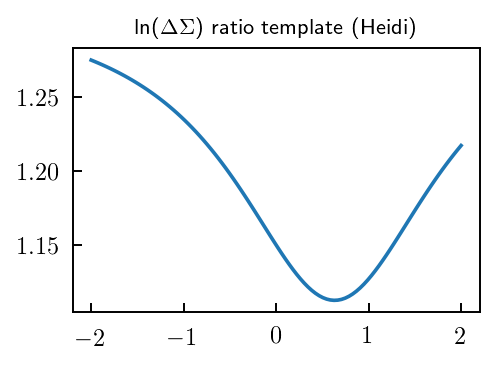

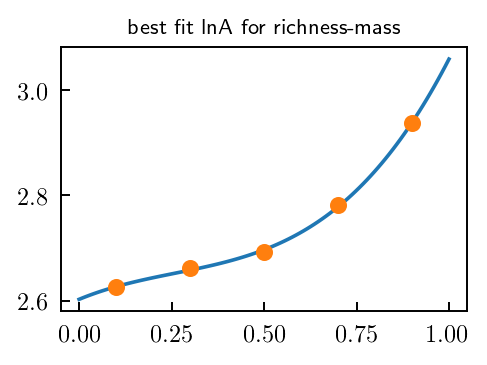

best fit B is  0.8672562498926204
best fit sig0 is  0.4646067757219166


In [40]:
if __name__=="__main__":
    import sys
    sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
    from mpl_toolkits.mplot3d import Axes3D
    from tools.setup.setup import tools_home_dir, home_dir
    import pyfits
    shapedir = home_dir()+'output/buzzard/halo_shape/'
    tpltdir = home_dir() + 'output/lmda_cosi_chains/'
    toolsdir = tools_home_dir()
    homedir = home_dir()
    
    #Test the DS template
    x = np.linspace(-2,2,100)
    DS_template = np.exp(lnDS_ratio(0.9, x))
    plt.figure(figsize=(3,2))
    plt.plot(x, DS_template)
    plt.title(r'ln($\Delta\Sigma$) ratio template (Heidi)', fontsize=9)
    plt.show()
    
    #Bin by cosine
    from repo.halo_shape.read_shape_param import halo_bin_stat
    #Bin by cosine
    cosi_num_bin = 5
    cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
    cosi_bins = []
    for i in range(cosi_num_bin):
        cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
        
        
    #Testing interpolate_lnA
    cosi_mid, spl_lnA, data_lnA = interpolate_A(tpltdir, cosi_bins)
    x = np.linspace(0,1,100)
    plt.figure(figsize=(3,2))
    plt.plot(x, spl_lnA(x))
    plt.plot(cosi_mid, data_lnA, 'o')
    plt.title('best fit lnA for richness-mass', fontsize=9)
    plt.show()
    
    B_allfit = bestfit_B(tpltdir)
    sig0_allfit = bestfit_sig0(tpltdir)
    print "best fit B is ", B_allfit
    print "best fit sig0 is ", sig0_allfit
